# 读入数据listing
   分析思路：
   1.list的信息是基本房源基础信息，包括房源、房东、位置、类型、价格、评论数量和可租时间等等，可以从不同区的各个角度去分析，也可以从房价的时间序列去分析,还可以从评论的文本信息去分析；
   2.整体上数据的缺失情况不是很严重，建模时可以去除掉缺失严重的列，对不严重的列进行填充分析。

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline  
list1 = pd.read_csv("listings.csv")
print("数据的大小是",list1.shape)
print("数据大致结构是",list1.tail(5))
#观察缺失情况  
list1.shape
list1_null = list1.isnull().sum(axis=0).sort_values(ascending=False)/float(len(list1))
print("数据的缺失情况是\n",list1_null)


数据的大小是 (28452, 16)
数据大致结构是              id                                               name    host_id  \
28447  33948728                            望京西门子,798,央美附近 温馨如家大床民宿  256112655   
28448  33948787                  04简约舒适电梯房/工体/三里屯/东大桥/朝阳医院/世贸天阶/国贸  147335664   
28449  33950006                                     临近地铁温馨网红风小屋一居室  141786513   
28450  33950535                               3. 老国展,三元桥地铁,静安东里大床房  213500128   
28451  33954414  密码锁自行入住,隐私安全,丰台宋家庄交通枢纽站,去往北京站北京南站,天安门故宫,长城水魔方,...  252799678   

      host_name  neighbourhood_group   neighbourhood  latitude  longitude  \
28447         旭                  NaN  朝阳区 / Chaoyang  39.98671  116.47394   
28448      Pony                  NaN  朝阳区 / Chaoyang  39.92560  116.44735   
28449         昊                  NaN  朝阳区 / Chaoyang  39.89733  116.50473   
28450        晓征                  NaN  朝阳区 / Chaoyang  39.95988  116.45187   
28451         超                  NaN   丰台区 / Fengtai  39.84714  116.43481   

             room_type 

## 不同区不同维度分析
租房信息呈放射状分布，说明大部分的租房还是比较集中，偏远的地方比较分散，说明市区的租房需求大多数集中在市区。


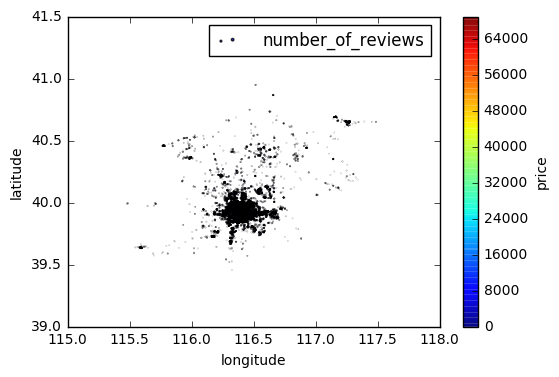

In [2]:
# 地理数据可视化
list1.plot(kind='scatter', x='longitude', y='latitude', alpha=0.8, s=list1['number_of_reviews']/100, label='number_of_reviews', c='price', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

租房个数排行在前三的区是朝阳区，东城区，海定区，但是租房均价价格分布在600左右，但是价格最高的是怀柔区、延庆县、昌平区、平谷区。租房的价格和人数呈一定的反比关系，租房价格越高的区，人数相对较少。

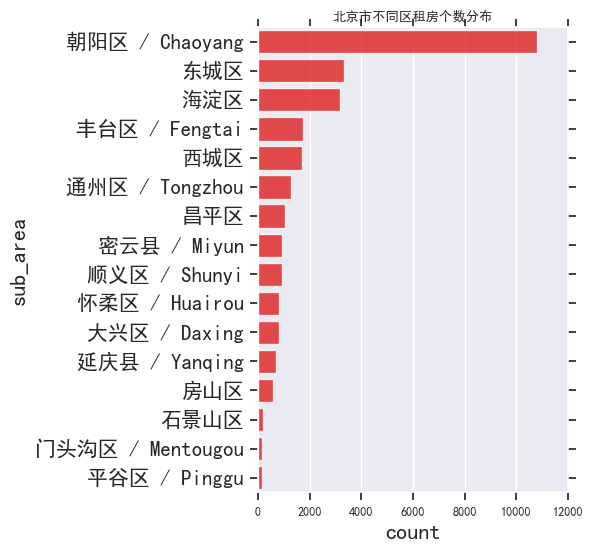

In [4]:
#对不同的区域分布式的个数统计
df = pd.value_counts(list1["neighbourhood"])
df = pd.DataFrame(df)
df["region"] = df.index
region = list(df["region"])
neigh = list(df["neighbourhood"])
f, ax=plt.subplots(figsize=(4,6))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.set(font='SimHei',font_scale=0.8)  # 解决Seaborn中文显示问题并调整字体大小
g = sns.barplot(y=region, x=neigh,orient='h', alpha=0.8, color='red')
plt.ylabel('sub_area', fontsize=16)  #设置y轴、X轴的坐标名字与字体大小
plt.xlabel('count', fontsize=16)
plt.xticks(rotation='horizontal') #设置X轴的各列下标字体是水平的
plt.yticks(fontsize=15)  #设置Y轴下标的字体大小
plt.title('北京市不同区租房个数分布')
plt.show()

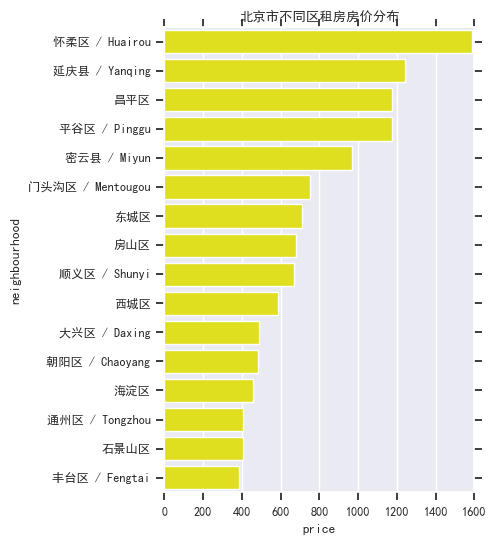

In [5]:
#不同区价格分布
neigh_price = list1['price'].groupby(list1["neighbourhood"]).mean().reset_index()
neigh_price = neigh_price.sort_values(by = 'price',ascending=False)
neigh_price
f, ax=plt.subplots(figsize=(4,6))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.set(font='SimHei',font_scale=0.8)  # 解决Seaborn中文显示问题并调整字体大小
g1 = sns.barplot(y = neigh_price.neighbourhood, x = neigh_price.price,color='yellow')
plt.title('北京市不同区租房房价分布')
plt.show()#显示预测值与测试值曲线

最火热的房子是东城区的租房，延庆县的人气最低；对不同的区的租房的一年可用天数取平均值，基本上大多数的房子一年可租用的天数都在200以上，通州区的一年可用天数最多。

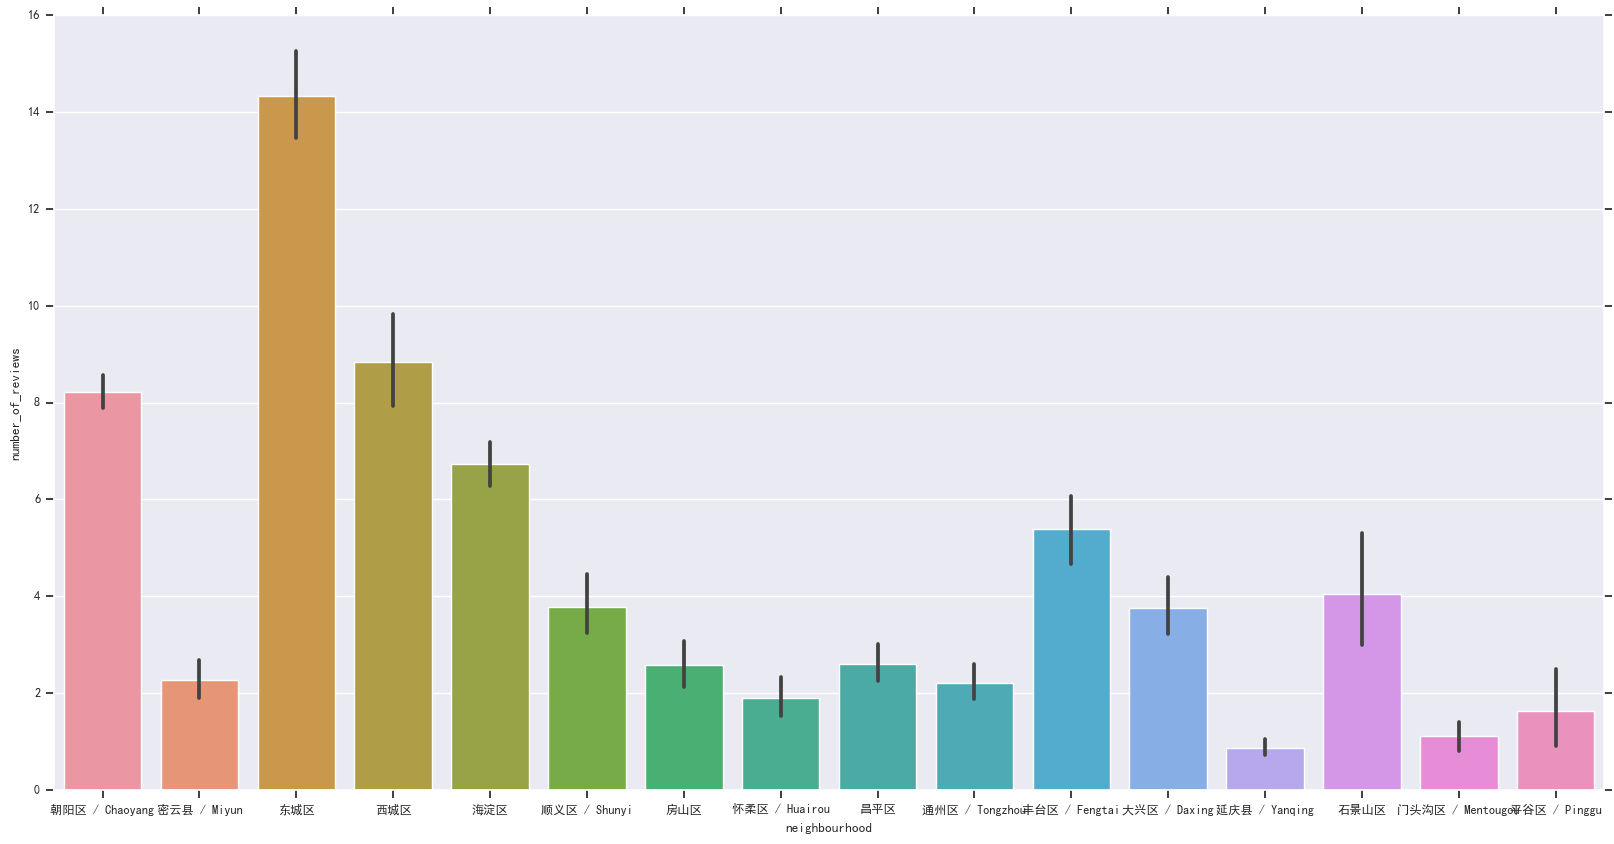

In [6]:
#哪一块的房子评论分布
f,ax = plt.subplots(figsize=(20,10))
sns.barplot(x = 'neighbourhood',y='number_of_reviews',data=list1)
#sns.barplot(x='neighbourhood',y='number_of_reviews',hue='room_type',data = list1, estimator=sum)

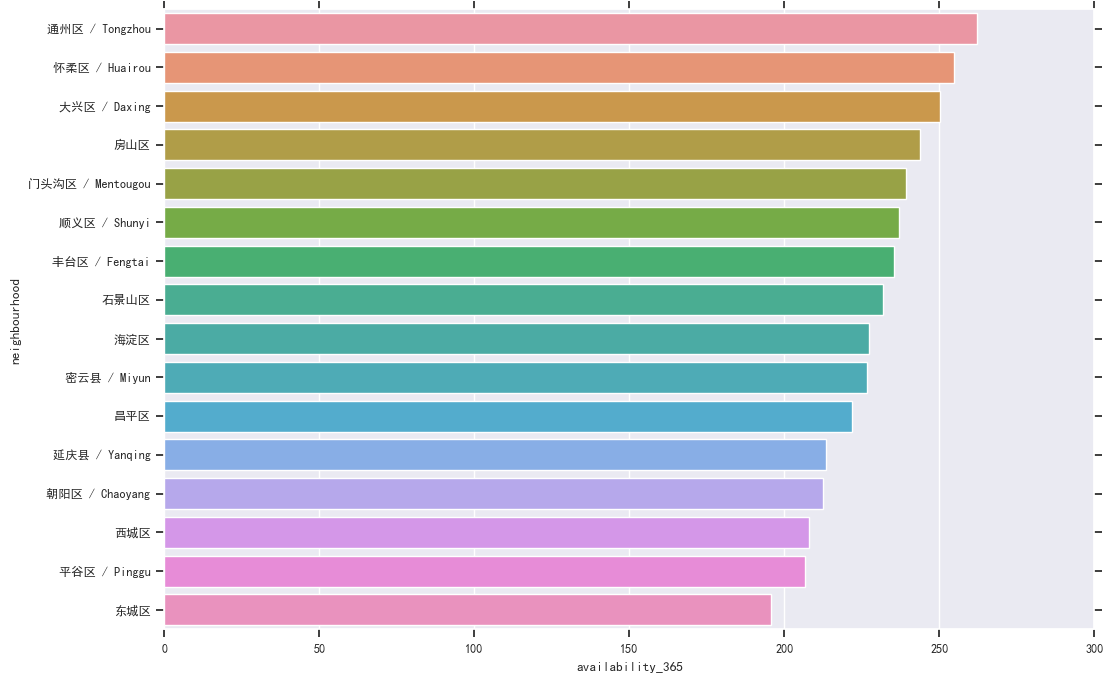

In [7]:
# 哪一块的房子一年可居住天数的分布
from numpy import mean
f,ax = plt.subplots(figsize=(12,8))
grouped_host = list1['id'].groupby(list1["host_id"]).count().reset_index()
availability_cnt = list1["availability_365"].groupby(list1['neighbourhood']).mean().reset_index().sort_values("availability_365",ascending=False)
sns.barplot(x='availability_365',y='neighbourhood',data = availability_cnt)

# 对房价对时序分析
将数据中的评论时间近似成房屋价格的时间，观察不同时间段的房租价格的变化。首先对有缺失值的行进行删除，因为数据量比较多，可视化效果不好，所以对时间按照月份进行下采样，对价格求均值，然后观察不同时间的租房价格的变化。日期从2012年9月到2019年4月，月份不一定连续。
2016年6月的数据可视为异常值，整体看2012到2019年的租房价格有小幅度的上升，2017年到2019年的波动性相对前几年比较大。


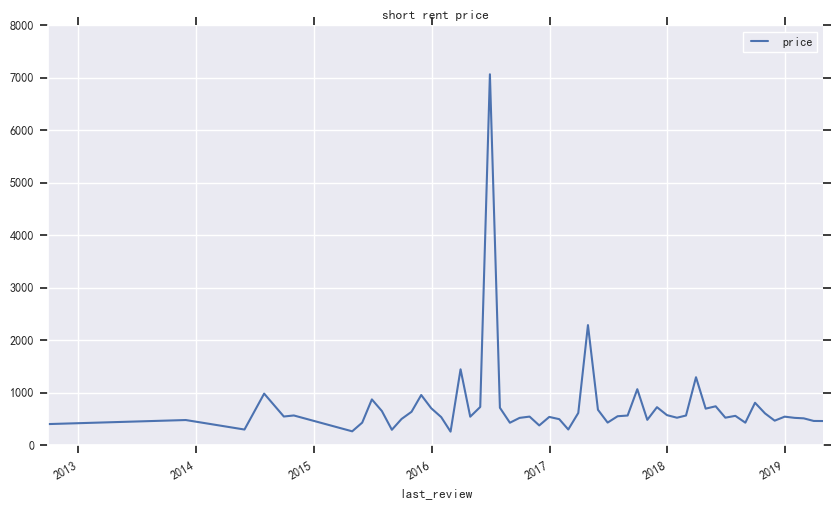

In [8]:
df_price = list1[['id','price','last_review']]
#print(df_price.isnull().sum())
df_price.describe()
df_price = df_price.dropna(axis = 0) #筛选没有缺失值的price分析数据
df_price_sort = df_price.sort_values(by = 'last_review') #对房价按照时间进行排序
time_price = df_price_sort[["last_review","price"]]
time_price.index = time_price.last_review   #需要将索引置为日期
del time_price['last_review']
time_price.index = pd.to_datetime(time_price.index)
price_m = time_price.resample("M").mean()  #下采样
price_m = price_m.dropna()
price_m.plot(figsize=(10,6))
plt.title("short rent price")
sns.despine()
#price_m

## 对租房信息进行文本词云展示
在租房信息中，可以看出地铁占据了比较重要的因素

(28452, 16)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\10912\AppData\Local\Temp\jieba.cache
Loading model cost 1.007 seconds.
Prefix dict has been built succesfully.


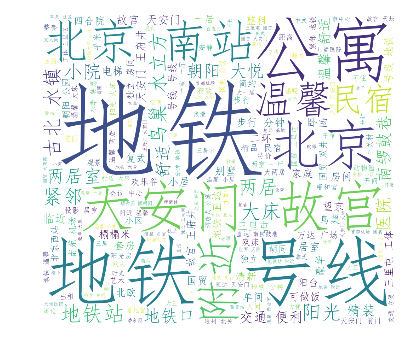

In [9]:
from wordcloud import WordCloud
import jieba
import re 
print(list1.shape)

def is_have_alpha(line):
    a = re.findall('[a-zA-Z]',line) 
    if a == []:
        return line
    else:
        return []

list1 = list1.dropna(subset=['name'])
list1["name2"] = list1["name"].apply(lambda x:is_have_alpha(x)) 
txt = list1[["name2"]]    
txt.index = np.arange(txt.shape[0])
txt2 = []
for i in range(txt.shape[0]):
    #print(txt.ix[i,:].values)
    txt2 += list(txt.ix[i,:].values)    
txt3 = list(filter(lambda x:x!=[],txt2))  #过滤掉空的列表值
txt4=' '.join(txt3)   #txt3是列表 不能用列表直接相加 要用join  否则每个字都会当做一个字符
cut_txt = " ".join(jieba.cut(txt4))   
wordcloud = WordCloud(
    #设置字体，不然会出现口字乱码，文字的路径是电脑的字体一般路径，可以换成别的
    font_path="C:/Windows/Fonts/simfang.ttf",
   #设置了背景，宽高
   background_color="white",width=1000,height=880,max_words = 200).generate(cut_txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## 房屋价格预测模型
数据由房屋数据和房屋明细数据两部分组成，其中的变量进行了挑选，最终形成一个整体的数据集。

In [10]:
#建立子数据集
list_detail = pd.read_csv("listings_detail.csv")
df_temp1 = list1[["id","price","room_type","neighbourhood","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]]
df_temp2 = list_detail[["id","property_type","room_type","accommodates","bathrooms","bedrooms","beds","minimum_nights","maximum_nights",\
"minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",\
"minimum_nights_avg_ntm","maximum_nights_avg_ntm","availability_30","availability_60","availability_90","availability_365",\
"number_of_reviews","number_of_reviews_ltm","first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness",\
"review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","requires_license","license",\
"jurisdiction_names","instant_bookable","is_business_travel_ready","cancellation_policy","require_guest_profile_picture",\
"require_guest_phone_verification","calculated_host_listings_count","calculated_host_listings_count_entire_homes",\
"calculated_host_listings_count_private_rooms",\
"calculated_host_listings_count_shared_rooms","reviews_per_month"]]
cols_to_use = df_temp2.columns.difference(df_temp1.columns)   #两个数据框会有重复的列 先找出不同的 再进行合并
cols_to_use = list(cols_to_use)
cols_to_use2 = ["id",'accommodates', 'availability_30', 'availability_60', 'availability_90', 'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'cancellation_policy', 'first_review', 'instant_bookable', 'is_business_travel_ready', 'jurisdiction_names', 'last_review', 'license', 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm', 'number_of_reviews_ltm', 'property_type', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value']
df_temp2 = df_temp2[cols_to_use2]
df_merge = pd.merge(df_temp1,df_temp2,on='id',how='inner')
#df_merge.tail(1000).to_excel("df_merge.xlsx")

观察数据变量的缺失情况，删除掉缺失率大于30%的变量，将其他的缺失值用众数填充（本案例中缺失的都是分类型的变量）

In [11]:
#观察缺失值的情况
data_null = df_merge.isnull().sum(axis=0).sort_values(ascending=False)*100/(len(df_merge))
#print(data_null)
#删除缺失率大于30%的变量
#type(data_null[data_null>=40])
for col in data_null[data_null>30].index.tolist():
    del df_merge[col]
    print("变量{}已删除".format(col))    

变量jurisdiction_names已删除
变量license已删除
变量review_scores_value已删除
变量review_scores_location已删除
变量review_scores_checkin已删除
变量review_scores_communication已删除
变量review_scores_cleanliness已删除
变量review_scores_accuracy已删除
变量review_scores_rating已删除
变量first_review已删除
变量last_review已删除
变量reviews_per_month已删除


In [12]:
from sklearn.preprocessing import Imputer
warnings.filterwarnings('ignore')
df_merge.head()
#对变量缺失值进行填充
data_null2 = df_merge.isnull().sum(axis=0).sort_values(ascending=False)*100/(len(df_merge))
#区分变量的类型 分成连续型变量和分类型变量
df_type = pd.DataFrame({"col":df_merge.dtypes.index, "type":df_merge.dtypes.values})
cat = df_type[df_type["type"] == object]
num = df_type[df_type["type"] != object]
cat = list(cat["col"])
num = list(num["col"])
num = list(set(num) - set(["id"]))
#print(num)
#缺失值用众数填充
null_cols = list(data_null2[data_null2>0].index) #找出需要填充的变量
df_merge[null_cols] = Imputer(missing_values="NaN",strategy="most_frequent").fit_transform(df_merge[null_cols])

# 变量探索
连续型变量箱线图展示，从箱线图可以看出 大多数连续型变量分布不是很均匀；直方图也可以看出，大多数变量集中在值比较小的地方，几乎没有呈现正态分布的连续型变量。

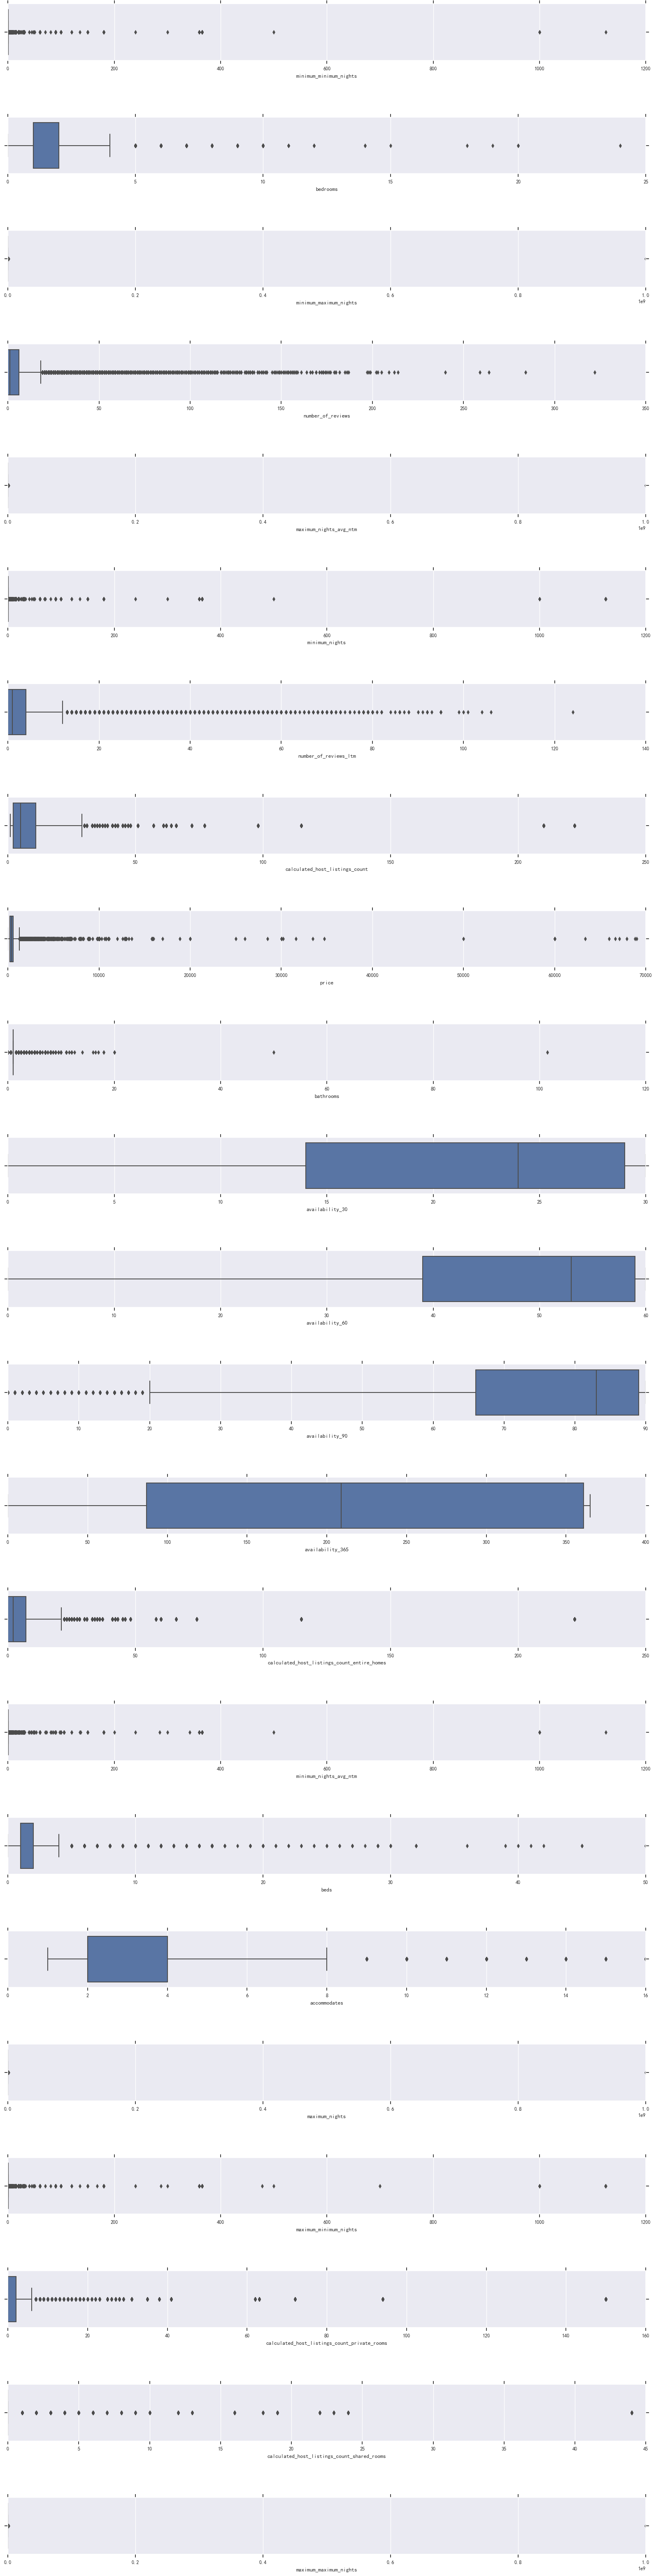

In [13]:
#print(df_merge.describe())  # 获取所有变量大致分布
f,ax = plt.subplots(len(num),1,figsize=(20,80))
plt.subplots_adjust(hspace=1)
for i,col in enumerate(num):
    sns.boxplot(df_merge[col],ax=ax[i],whis=2,orient='h')    

<function matplotlib.pyplot.show>

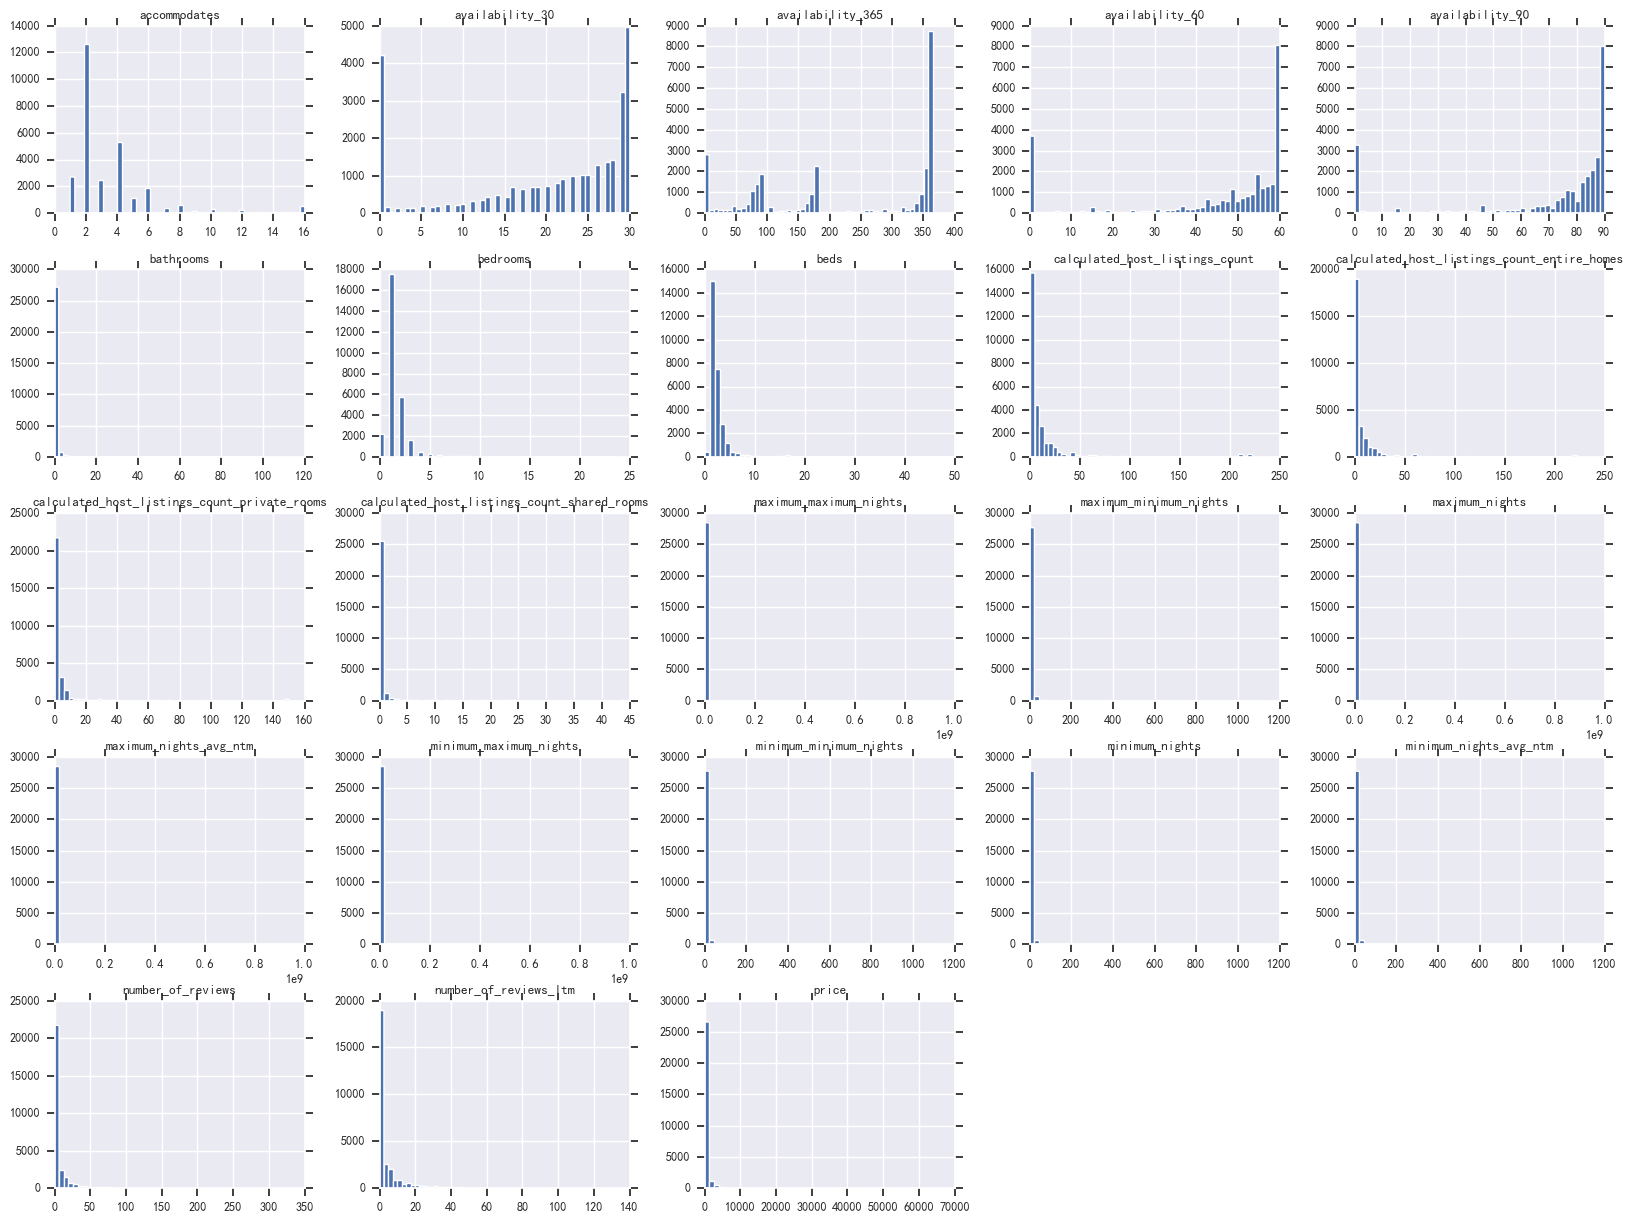

In [33]:
#对变量做直方图看分布
df_merge[num].hist(bins=50, figsize=(20,15))
plt.show

从直方图中可以看出因变量price有明显的右偏，同时也存在异常变量，可以将大于10000的去掉。统计得，大于10000的变量约中总数的0.1%，数据变化之后可以更便捷的统计推断，比如进行t检验，方差检验和回归分析，通常所需要的估计量是均值加上两倍的标准差。

0.0016871111735967102


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000278E8AE9390>]], dtype=object)

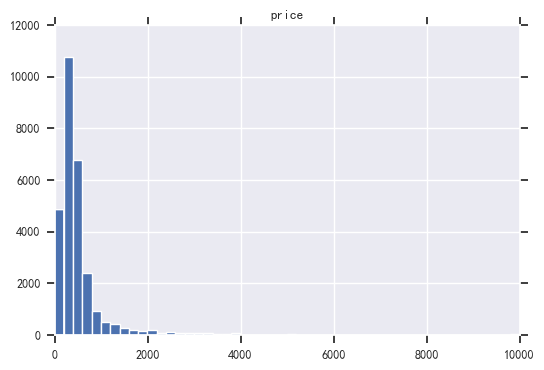

In [14]:
#先从因变量分析 
print(len(df_merge[df_merge["price"] >= 10000])/df_merge.shape[0])  #观察大于10000的占比
df_merge2 = df_merge[df_merge["price"]<10000]  #去掉大于10000的数据
df_merge2[['price']].hist(bins=50)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000278EC1CABA8>]], dtype=object)

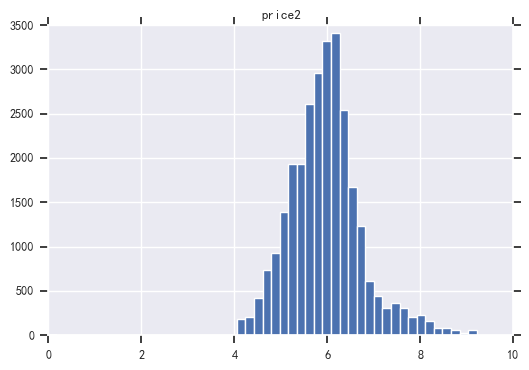

In [15]:
df_merge2["price2"] = df_merge2["price"].map(lambda x:np.log(1+x))
df_merge2[['price2']].hist(bins=50)

数据倾斜问题：观察数据的倾斜情况，如果有严重倾斜的，可以做离散化处理，删除掉偏差在80%的变量

In [16]:
col_mode = dict()
col_mode = {col:pd.value_counts(df_merge2[col]).values[0]/df_merge2.shape[0] for col in df_merge2.columns.tolist()}
col_mode_sort = dict(sorted(col_mode.items(),key = lambda x:x[1], reverse=True))
col_mode_sort
for col,value in col_mode_sort.items():
    if value >= 0.7:
        del df_merge2[col]
    else:
        pass
del df_merge2["id"]

## 变量之间的相关关系
#连续型变量：先观察每个变量和因变量之间的相关关系，并且删除负相关的变量。
#离散型变量：用单因素方差分析（单因素方差分析是用于分析连续型因变量和离散型自变量的相关关系，观察自变量的不同取值是否会对因变量产生影响）
#单因素方差分析其实就是用组间平方和和组内平方和做对比，如果差别不大，则说明是误差引起的，则不拒绝原假设。

In [17]:
#自变量中连续变量和因变量的相关关系
corr_matrix = df_merge2.corr()
df_corr = corr_matrix['price2'].sort_values(ascending=False)
#删除负相关的变量
num2 = list(df_corr[df_corr>0].index)

In [19]:
#自变量中离散型变量和因变量的相关关系（用单因素方差分析）
import pandas as pd
#from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
cat2 = [i for i in cat if i in df_merge2.columns.tolist()]
for col in cat2:
    model = ols('price2 ~ '+str(col),df_merge2).fit()
    anovat = anova_lm(model)
    print(col, anovat.ix[0,-1])


#变量处理与模型建立
#对于无序型的自变量要进行哑变量处理，将哑变量和其他变量合并，形成新的建模数据集。

In [20]:
#分类变量做哑变量处理
df_dummies = pd.DataFrame()
for col in cat2:
    dummies=pd.get_dummies(df_merge2[col],prefix='key')
    #print(dummies.head())
    df_dummies = pd.concat([df_dummies,dummies],axis = 1)
#dummies1.join(dummies2)
print(df_dummies.shape)

(28403, 66)


In [21]:
#形成新的数据集，并进行建模
num3 = [i for i in num2 if i in df_merge2.columns.tolist()]
df_all = pd.concat([df_dummies,df_merge2[num3]],axis=1)
df_all["price2"] = df_all["price"].map(lambda x:np.log(1+x))
df_all.head()
df_all.columns.tolist()
del df_all["price"]
#检查是否有缺失值
list1_null = list1.isnull().sum(axis=0).sort_values(ascending=False)/float(len(list1))
#df_all.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df_all))

#对变量和因变量做可视化 观察相关性，可以看出"accommodates","bedrooms","beds"这三个变量和因变量并不是呈明显的相关关系。

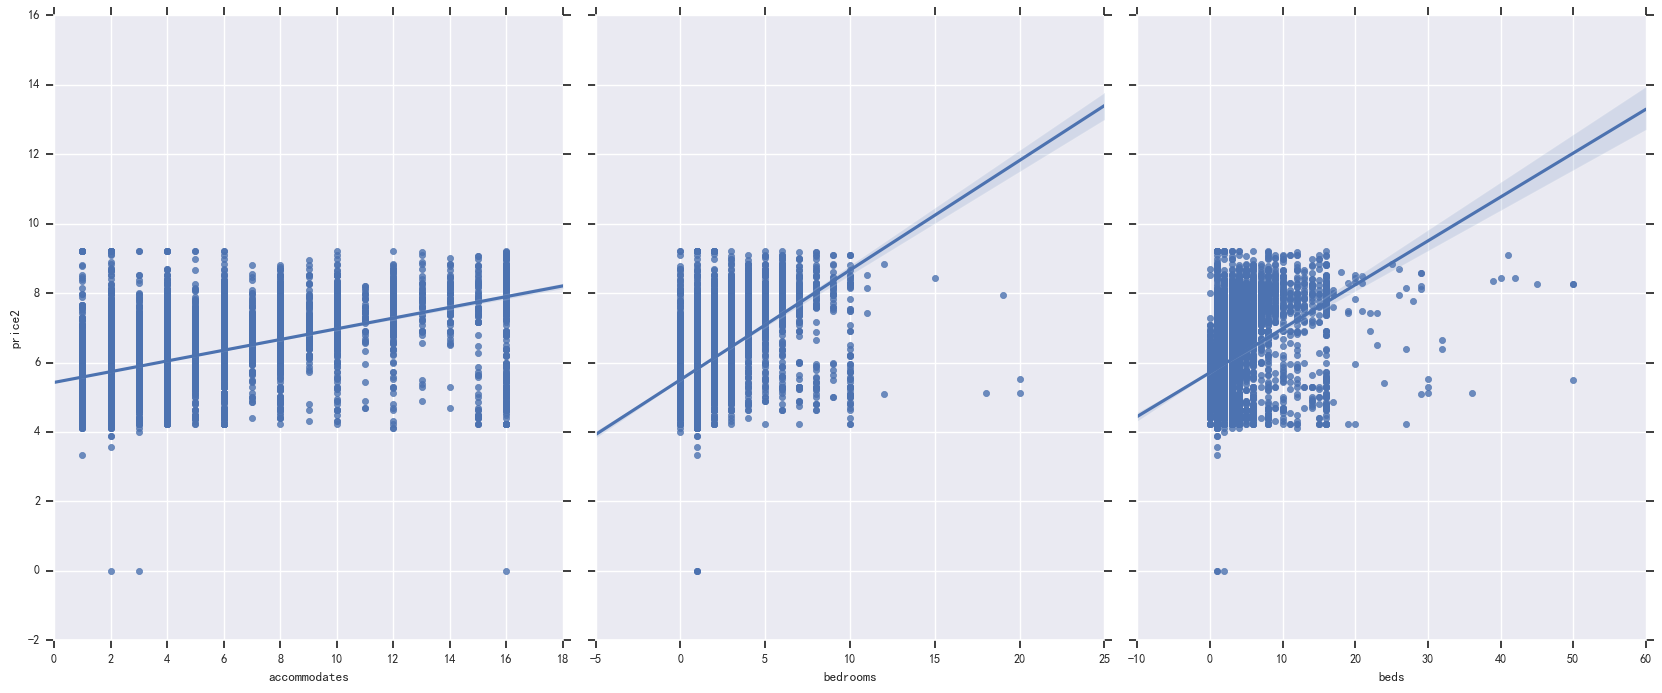

In [22]:
# num4 = ["accommodates","bedrooms","beds","availability_90","availability_60","availability_365",\
#                              "availability_30","calculated_host_listings_count_entire_homes","calculated_host_listings_count"]
sns.pairplot(df_all, x_vars=["accommodates","bedrooms","beds"], y_vars='price2', size=7, height = 1, aspect=0.8,kind = 'reg',
           )
#plt.savefig("pairplot.jpg")
plt.show()

#构建多元线性回归模型，划分训练集和测试集，得出模型的截距和回归系数，并预测出测试集的值。

In [60]:
#构建模型
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
features = list(set(df_all.columns.tolist()) - set(["price2"]))
X_train,X_test,Y_train,Y_test = train_test_split(df_all[features], df_all["price2"], test_size=0.3, random_state=None)
model = LinearRegression() 
model.fit(X_train,Y_train) 
a = model.intercept_#截距 
b = model.coef_#回归系数 
print("最佳拟合线:截距",a,",回归系数：",b)
# score = model.score(X_test,Y_test) 
# print(score) 
#对线性回归进行预测  求预测误差
Y_pred = model.predict(X_test) 
len(features)
dict_coef = dict(zip(list(features),list(model.coef_)))
dict_coef2 = dict(sorted(dict_coef.items(),key=lambda x:x[1],reverse=True))
dict_coef3 = {k:v for k,v in dict_coef2.items() if v >0}
print("观察变量的大于0的系数从大到小排序如下",dict_coef3)

最佳拟合线:截距 -874166142.876 ,回归系数： [  8.74166149e+08   8.74166148e+08   8.74166148e+08   8.74166148e+08
   2.58792311e-01   1.69169903e-03   1.43647194e-04   8.74166149e+08
   8.74166149e+08   9.08374786e-04   8.74166149e+08  -3.87616754e-02
  -6.25710934e-04  -3.14000010e-01   8.74166148e+08   8.74166147e+08
   8.74166148e+08   8.74166148e+08   6.78914785e-03  -1.49811774e-01
   8.74166149e+08   8.74166148e+08   8.51178169e-03  -1.89518929e-03
   8.74166148e+08   5.03442287e-02   8.74166148e+08   8.74166149e+08
  -5.26318401e-02   8.74166148e+08   8.74166148e+08   8.74166148e+08
   1.00499660e-01   2.14483470e-01  -6.45417869e-02  -8.67921114e-03
  -6.08667865e-01   8.74166148e+08   8.74166149e+08  -1.00253642e-01
   8.74166148e+08   8.74166148e+08   8.74166148e+08  -5.63693047e-03
   2.10344791e-03   1.50620937e-04  -1.21895406e-01  -3.38133425e-04
   8.74166148e+08   8.74166149e+08   9.26426053e-02   3.89398336e-02
   8.74166148e+08   8.74166148e+08   8.74166148e+08   1.52708381e-01
   

#模型评估
#预测误差：预测得出的值和真实的值的差的平方
#判定系数：该值越大，说明回归平方和越大，模型拟合的就越好。
#对与预测值的结果和测试集的值画图拟合，可以看出拟合的效果一般，判定系数的值是在0.55附近，说明该模型还要改进的空间。

预测误差平方和为 nan
判定系数为 0.55520347674
多元回归算法的各个特征的系数矩阵为 [  1.70142694e+09   1.70142693e+09   1.70142694e+09   1.70142693e+09
   2.63969064e-01   1.72615051e-04   1.70142693e+09   1.70142694e+09
   1.70142694e+09   1.70142693e+09   1.70142694e+09  -3.38827372e-02
   3.44380736e-03  -3.09591293e-01   1.70142693e+09   1.70142693e+09
   1.70142693e+09   1.70142693e+09   6.84881210e-03  -1.36445850e-01
   1.70142694e+09   1.70142693e+09   7.79873133e-03  -2.00438499e-03
   1.70142693e+09   5.06095886e-02   1.70142693e+09   1.70142694e+09
  -5.38756102e-02   1.70142693e+09   1.70142694e+09   1.70142694e+09
   1.10316634e-01   2.29991257e-01  -6.61004484e-02  -6.88469410e-03
  -6.16775930e-01   1.70142693e+09   1.70142694e+09  -9.96925235e-02
   1.70142693e+09   1.70142694e+09   1.70142694e+09  -3.82971764e-03
   1.44565105e-03   1.19805336e-04  -7.23195076e-02  -2.29853392e-03
   1.70142693e+09   1.70142694e+09   8.49096179e-02   4.23951149e-02
   1.70142693e+09   1.70142693e+09   1.70142693e+09 

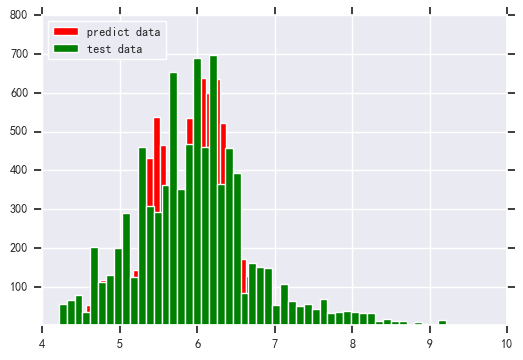

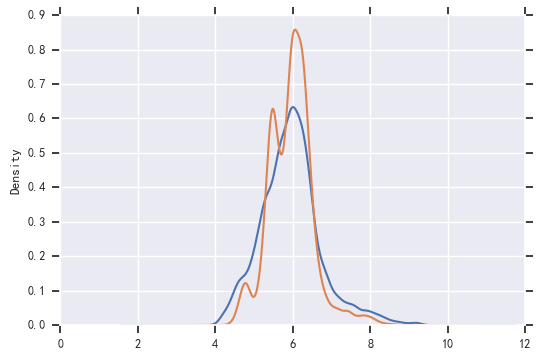

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  
#直接调用库函数进行输出R2
error = np.sum([i*i for i in Y_pred-Y_test])
print("预测误差平方和为",error)
print("判定系数为",r2_score(Y_test,Y_pred))
print("多元回归算法的各个特征的系数矩阵为",model.coef_)               #输出多元回归算法的各个特征的系数矩阵

type(np.array(df_all.columns.tolist()))
# print(np.argsort(model.coef_))  #输出多元线性回归算法各个特征的系数排序，可以知道各个特征的影响度
# #print(df_all.columns.tolist()[np.argsort(model.coef_)])  输出各个特征按照影响系数从小到大的顺序

#预测值和测试值的直方图
plt.hist(np.array(Y_pred), bins = 50, color = 'red',label="predict data")
plt.hist(np.array(Y_test), bins = 50, color = 'green',label="test data")
plt.ylim(1,800,1) 
plt.xlim(4, 10,1)
plt.legend(loc=2)
plt.show()#显示预测值与测试值曲线

#预测值和测试值的密度曲线
Y_pred = pd.Series(list(Y_pred))
Y_test.plot(kind='kde')
Y_pred.plot(kind='kde')



观察预测值的分布，呈大致的正态分布。

测试集的均值为: 5.9590548162170585
预测值的均值为: 5.962233247897978 预测值的最大值为: 8.61002111435 预测值的最小值为: 4.31251716614


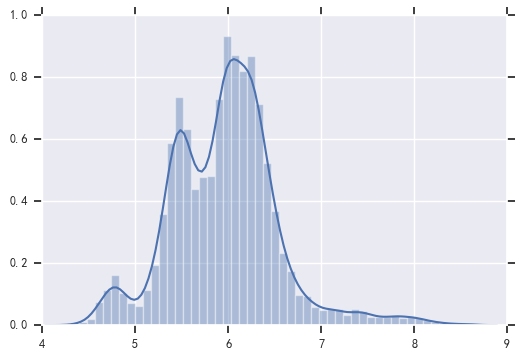

In [40]:
print("测试集的均值为:",Y_test.mean())
print("预测值的均值为:",Y_pred.mean(), "预测值的最大值为:",Y_pred.max(), "预测值的最小值为:",Y_pred.min())
sns.distplot(Y_pred)